In [11]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [12]:
# Check for GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
# Define transformations for Fashion MNIST
trf = transforms.Compose([
    transforms.Grayscale(3),  # Convert grayscale to 3-channel to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2860, 0.2860, 0.2860], std=[0.3530, 0.3530, 0.3530])  # Normalize pixel values
])


In [14]:
# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=trf, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=trf, download=True)

In [15]:
# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

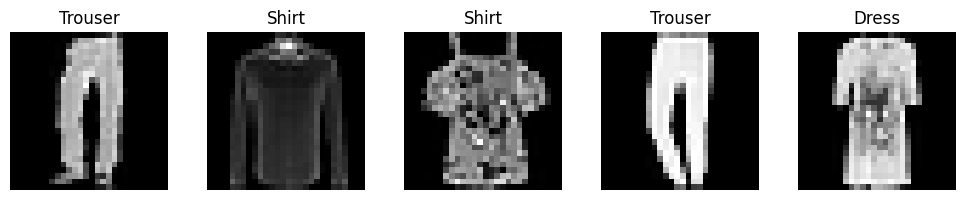

In [16]:
# print the images for refrence

import matplotlib.pyplot as plt

# Function to visualize n images from the train_loader
def show_images_from_train_loader(train_loader, n=5):
    """
    Displays n images from the train_loader with their labels.

    Args:
    train_loader (DataLoader): DataLoader for the training dataset.
    n (int): Number of images to display.
    """
    data_iter = iter(train_loader)
    images, labels = next(data_iter)  # Fetch a batch of images
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    plt.figure(figsize=(10, 2 * n // 5))
    for i in range(min(n, len(images))):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example: Display 5 images from train_loader
show_images_from_train_loader(train_loader, n=5)



In [17]:
# Define the FashionModel
class FashionModel(nn.Module):
    def __init__(self,dropout_prob):
        super(FashionModel, self).__init__()

        # Load ResNet18 with pre-trained weights
        pretrain = models.resnet18(pretrained=True)

        # Freeze the convolutional layers
        for param in pretrain.parameters():
            param.requires_grad = False

        # Get the number of features from the final fully connected layer of ResNet18
        features = pretrain.fc.in_features

        # Modify the fully connected layer to have 4 layers
        pretrain.fc = nn.Sequential(
            nn.Linear(features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),  # Output layer for 10 classes (Fashion MNIST)
        )

        # Store the modified model
        self.modified_model = pretrain

    def forward(self, x):
        # Forward pass through the modified model
        return self.modified_model(x)


In [18]:
def train_test(model, epochs, train_loader, test_loader, optimizer, loss_fn,patience,scheduler=None):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    best_loss = float('inf')
    patience_counter = 0


    for i in range(epochs):
        model.train()
        train_batch_loss = 0
        correct_train = 0
        total_train = 0
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Loss
            loss = loss_fn(y_pred, lbl)
            train_batch_loss += loss.item()
            # Accuracy
            total_train += lbl.shape[0]
            pred_lbl = torch.argmax(y_pred, dim=1)
            correct_train += (pred_lbl == lbl).sum().item()
            # Backpropagation
            loss.backward()
            # Update parameters
            optimizer.step()

        avg_train_loss = train_batch_loss / len(train_loader)
        batch_train_acc = correct_train / total_train*100
        train_loss.append(avg_train_loss)
        train_acc.append(batch_train_acc)

        # Testing phase
        model.eval()
        test_batch_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for img, lbl in test_loader:
                img, lbl = img.to(device), lbl.to(device)
                # Forward pass
                y_pred = model(img)
                # Loss
                loss = loss_fn(y_pred, lbl)
                test_batch_loss += loss.item()
                # Accuracy
                total_test += lbl.shape[0]
                pred_lbl = torch.argmax(y_pred, dim=1)
                correct_test += (pred_lbl == lbl).sum().item()

        avg_test_loss = test_batch_loss / len(test_loader)
        batch_test_acc = correct_test / total_test*100
        test_loss.append(avg_test_loss)
        test_acc.append(batch_test_acc)

        #Learning rate scheduling
        if scheduler:
            scheduler.step(avg_test_loss)

        #Early Stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at Epoch : {i + 1}")
                break

        print(f"Epoch: {i + 1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {batch_train_acc:.4f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {batch_test_acc:.4f}%")


    model.load_state_dict(torch.load('best_model.pth'))
    return train_loss, test_loss, train_acc, test_acc


In [19]:
def plot(epochs, train_loss, test_loss, train_acc, test_acc):
    epoch_numbers = list(range(1, epochs + 1))  # Create a list of epoch numbers
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epoch_numbers, train_loss, label='Train Loss')
    plt.plot(epoch_numbers, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epoch_numbers, train_acc, label='Train Acc')
    plt.plot(epoch_numbers, test_acc, label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



Epoch: 1, Train Loss: 1.6052, Train Acc: 43.0133%, Test Loss: 0.9800, Test Acc: 66.1700%
Epoch: 2, Train Loss: 1.0169, Train Acc: 63.6317%, Test Loss: 0.8538, Test Acc: 69.7000%
Epoch: 3, Train Loss: 0.9365, Train Acc: 66.6583%, Test Loss: 0.8018, Test Acc: 71.4400%
Epoch: 4, Train Loss: 0.8904, Train Acc: 68.0833%, Test Loss: 0.7772, Test Acc: 71.9100%
Epoch: 5, Train Loss: 0.8644, Train Acc: 68.7367%, Test Loss: 0.7472, Test Acc: 73.2800%
Epoch: 6, Train Loss: 0.8375, Train Acc: 69.8783%, Test Loss: 0.7361, Test Acc: 73.5900%
Epoch: 7, Train Loss: 0.8205, Train Acc: 70.2867%, Test Loss: 0.7292, Test Acc: 73.9700%
Epoch: 8, Train Loss: 0.8078, Train Acc: 70.8883%, Test Loss: 0.7093, Test Acc: 74.7400%
Epoch: 9, Train Loss: 0.7927, Train Acc: 71.2317%, Test Loss: 0.7023, Test Acc: 74.3200%
Epoch: 10, Train Loss: 0.7861, Train Acc: 71.4167%, Test Loss: 0.6912, Test Acc: 75.0100%


<ipython-input-18-4fdc7e5d77e8>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


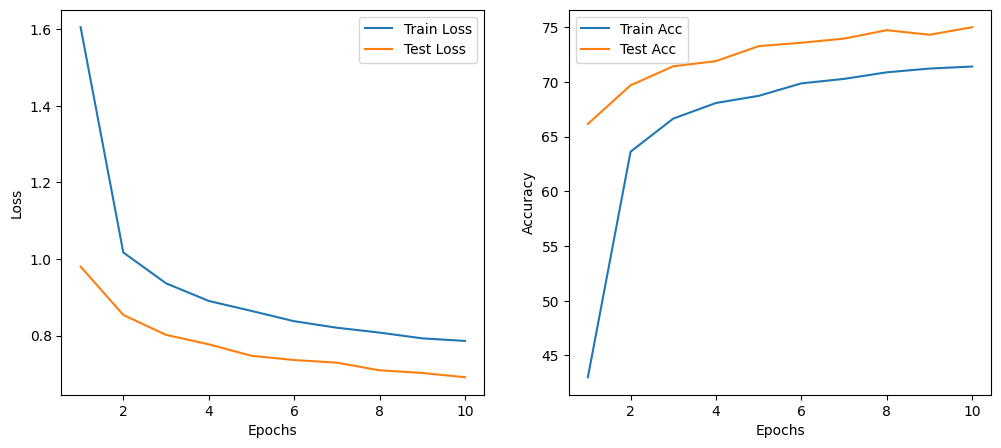

In [20]:
# Initialize model, optimizer, and loss function
model = FashionModel(dropout_prob=0.3).to(device)
lr = 0.009  # Lower learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
schdlr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

# Train and test the model
train_loss, test_loss, train_acc, test_acc = train_test(model, epochs, train_loader, test_loader, optimizer, loss_fn,5,schdlr)

# Plot the results
plot(epochs, train_loss, test_loss, train_acc, test_acc)
